In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.cuda.amp import autocast, GradScaler # Pour la vitesse et économie VRAM
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

# --- CONFIGURATION DU CHALLENGER ---
PROJECT_ROOT = r"C:\Users\amisf\Desktop\datascientest_projet"
# --- CORRECTION DU CHEMIN ---
IMG_DIR = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_train"
BATCH_SIZE = 16  # Plus petit car on charge tout le modele en VRAM
IMG_SIZE = (380, 380) # EfficientNet-B4 aime le 380x380 (plus précis que 224x224)
EPOCHS = 10 
LEARNING_RATE = 1e-4 # Plus fin car on fine-tune

# Vérification GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Moteur de combat : {torch.cuda.get_device_name(0)}")

🚀 Moteur de combat : NVIDIA GeForce RTX 4070


In [2]:
# Chargement du CSV
csv_path = os.path.join(PROJECT_ROOT, "data", "raw")
df_x = pd.read_csv(os.path.join(csv_path, "X_train_update.csv"), index_col=0)
df_y = pd.read_csv(os.path.join(csv_path, "Y_train_CVw08PX.csv"), index_col=0)
df = pd.merge(df_x, df_y, left_index=True, right_index=True)

# Création des chemins
df['filename'] = df.apply(lambda x: f"image_{x['imageid']}_product_{x['productid']}.jpg", axis=1)
df['path'] = df['filename'].apply(lambda x: os.path.join(IMG_DIR, x))

# Encodage Label
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['prdtypecode'])
NUM_CLASSES = len(le.classes_)

# Split (On garde moins de données pour le test rapide, tu pourras augmenter après)
# Pour le challenge, on prend tout le monde, mais ici on split pour valider
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label_encoded'], random_state=42)

print(f"✅ Données prêtes : {len(train_df)} train / {len(val_df)} val")

# --- DATASET PYTORCH ---
class ProductDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = row['label_encoded']
        
        # Chargement image
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            # Fallback si image corrompue (rare mais possible)
            image = Image.new('RGB', IMG_SIZE, (0,0,0))
            
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# Augmentation costaud pour le Fine-Tuning
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE), # Plus grand = plus de détails
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loaders
train_ds = ProductDataset(train_df, transform=train_transforms)
val_ds = ProductDataset(val_df, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

✅ Données prêtes : 76424 train / 8492 val


📸 Vérification Batch : 16 images
   Shape : torch.Size([16, 3, 380, 380])
   Min Pixel: -2.12 | Max Pixel: 2.64


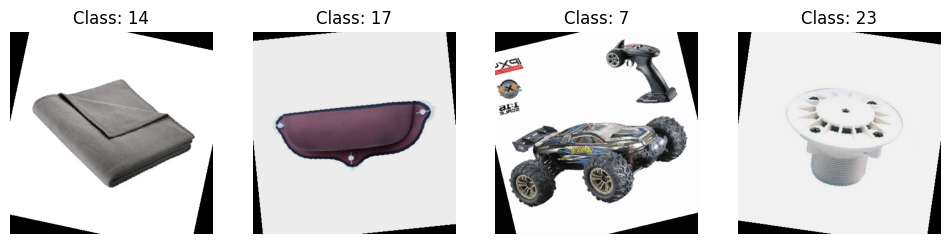

In [3]:
# --- SANITY CHECK : QU'EST-CE QUE LE MODÈLE VOIT ? ---
# On va afficher un batch tel qu'il arrive dans le GPU
dataiter = iter(train_loader)
images, labels = next(dataiter)

# On dé-normalise pour l'affichage (sinon les couleurs sont bizarres)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

print(f"📸 Vérification Batch : {len(images)} images")
print(f"   Shape : {images.shape}")
print(f"   Min Pixel: {images.min():.2f} | Max Pixel: {images.max():.2f}")

plt.figure(figsize=(12, 4))
for i in range(4):
    ax = plt.subplot(1, 4, i+1)
    # De-normalization
    img_show = images[i] * std + mean
    img_show = img_show.clamp(0, 1) # Force entre 0 et 1
    
    plt.imshow(img_show.permute(1, 2, 0)) # C,H,W -> H,W,C
    label_id = labels[i].item()
    label_name = le.inverse_transform([label_id])[0]
    plt.title(f"Class: {label_id}")
    plt.axis('off')
plt.show()

In [4]:
print("🛠️ Construction du Challenger : EfficientNet-B4 (Mode Stratégique)...")

# 1. Chargement du modèle
model = models.efficientnet_b4(weights="IMAGENET1K_V1")

# 2. ON GELE TOUT LE RÉSEAU (Le corps ne bouge pas)
for param in model.parameters():
    param.requires_grad = False

# 3. On remplace la tête (Par défaut, une nouvelle couche a requires_grad=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(device)
print("✅ Modèle chargé. CORPS GELÉ 🧊 / TÊTE ACTIVE 🔥")

🛠️ Construction du Challenger : EfficientNet-B4 (Mode Stratégique)...
✅ Modèle chargé. CORPS GELÉ 🧊 / TÊTE ACTIVE 🔥


In [ ]:
# Configuration
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() # Pour la vitesse

# --- PHASE 1 : WARMUP (On entraîne juste la tête) ---
# Learning rate fort car on doit apprendre de zero la derniere couche
optimizer_head = optim.AdamW(model.classifier.parameters(), lr=1e-3)

print("\n🔥 PHASE 1 : WARMUP (3 Epoques - Tête uniquement)...")
print("Le but est de faire descendre la Loss sous 2.0 rapidement.")

for epoch in range(3):
    model.train()
    run_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer_head.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer_head)
        scaler.update()
        
        run_loss += loss.item()
        if i % 50 == 0: print(f"   Warmup Batch {i} - Loss: {loss.item():.4f}", end="\r")
        
    print(f"\n   ✅ Fin Warmup Epoch {epoch+1} - Loss Moyenne: {run_loss/len(train_loader):.4f}")

# --- PHASE 2 : FINE TUNING TOTAL ---
print("\n🔓 DÉBLOCAGE DU RÉSEAU COMPLET...")
# On débloque tout
for param in model.parameters():
    param.requires_grad = True

# Learning rate TRÈS FAIBLE pour ne pas casser ce qu'il sait déjà
optimizer_full = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

print("🔥 PHASE 2 : FINE TUNING (7 Epoques - Tout le réseau)...")
print("Là, le F1 score doit décoller.")

history = {'val_f1': []}

for epoch in range(7): # 7 Epoques restantes
    model.train()
    run_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer_full.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer_full)
        scaler.update()
        
        run_loss += loss.item()
        if i % 50 == 0: print(f"   FineTune Batch {i} - Loss: {loss.item():.4f}", end="\r")

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n   🏁 Fin Epoch {epoch+1} (Phase 2) -> Val F1: {val_f1:.4f}")
    
    # Sauvegarde si ça devient bon
    if val_f1 > 0.80: 
        torch.save(model.state_dict(), os.path.join(PROJECT_ROOT, "implementation", "outputs", f"best_efficientnet_b4_f1_{val_f1:.4f}.pth"))

print("🚀 Terminé.")

C:\Users\amisf\AppData\Local\Temp\ipykernel_17716\2482221835.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # Pour la vitesse
C:\Users\amisf\AppData\Local\Temp\ipykernel_17716\2482221835.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🔥 PHASE 1 : WARMUP (3 Epoques - Tête uniquement)...
Le but est de faire descendre la Loss sous 2.0 rapidement.
   Warmup Batch 4750 - Loss: 1.4566
   ✅ Fin Warmup Epoch 1 - Loss Moyenne: 1.9999
   Warmup Batch 4750 - Loss: 2.1676
   ✅ Fin Warmup Epoch 2 - Loss Moyenne: 1.7662
   Warmup Batch 4750 - Loss: 1.7426
   ✅ Fin Warmup Epoch 3 - Loss Moyenne: 1.7397

🔓 DÉBLOCAGE DU RÉSEAU COMPLET...
🔥 PHASE 2 : FINE TUNING (7 Epoques - Tout le réseau)...
Là, le F1 score doit décoller.


C:\Users\amisf\AppData\Local\Temp\ipykernel_17716\2482221835.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


   FineTune Batch 4750 - Loss: 1.3701
   🏁 Fin Epoch 1 (Phase 2) -> Val F1: 0.6164


C:\Users\amisf\AppData\Local\Temp\ipykernel_17716\2482221835.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


   FineTune Batch 4050 - Loss: 0.8917

In [ ]:
# fonction permet de visualiser la "carte de chaleur" de l'attention du modèle

def visualize_gradcam(model, image_tensor, original_image):
    model.eval()
    
    # On cible la dernière couche de convolution d'EfficientNet
    # Pour B4, c'est souvent 'features'[-1]
    target_layer = model.features[-1]
    
    # Variables pour stocker les gradients
    gradients = None
    activations = None
    
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]
        
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
        
    # On attache les espions (hooks)
    handle_b = target_layer.register_full_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)
    
    # Forward
    output = model(image_tensor.unsqueeze(0).to(device))
    pred_idx = output.argmax(dim=1).item()
    
    # Backward pour avoir les gradients de la classe prédite
    model.zero_grad()
    output[0, pred_idx].backward()
    
    # Génération de la Heatmap (Grad-CAM math)
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0) # ReLU
    heatmap /= torch.max(torch.tensor(heatmap)) # Normalisation
    
    # Nettoyage
    handle_b.remove()
    handle_f.remove()
    
    # Superposition sur l'image
    heatmap = cv2.resize(heatmap.numpy(), (original_image.size[0], original_image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Conversion image originale en numpy pour cv2
    img_np = np.array(original_image)
    if len(img_np.shape) == 2: img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    
    return superimposed, le.inverse_transform([pred_idx])[0]

# --- TEST SUR QUELQUES IMAGES ---
print("🔍 Analyse de l'attention du modèle (Grad-CAM)...")

# On prend 3 images au hasard du dataset de validation
indices = np.random.choice(len(val_ds), 3)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    img_tensor, label_idx = val_ds[idx]
    
    # On recharge l'image "brute" pour l'affichage (sans normalisation)
    img_path = val_df.iloc[idx]['path']
    original_img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    
    # Calcul Grad-CAM
    cam_img, pred_classname = visualize_gradcam(model, img_tensor, original_img)
    
    true_classname = le.inverse_transform([label_idx.item()])[0]
    
    plt.subplot(1, 3, i+1)
    plt.imshow(cam_img)
    plt.title(f"Vrai: {true_classname}\nPrédit: {pred_classname}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
print("Rouge = Zone déterminante pour la décision de l'IA.")